In [1]:
pip install pdfplumber python-docx nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 115.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Preprocessing Resumes & Job Descriptions

In [3]:
import os
import re
import nltk
import docx
import pdfplumber

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ✅ Ensure NLTK Dependencies are Installed
nltk.data.path.append("A:/nltk_data")  # Add A: drive to NLTK path

# Download necessary NLTK resources (Check before downloading)
nltk.download("punkt", quiet=True)
nltk.download('punkt_tab')
nltk.download("stopwords", quiet=True)

try:
    stop_words = set(stopwords.words("english"))
except Exception as e:
    print(f"❌ Error loading stopwords: {e}")
    stop_words = set()

# ✅ Define a sample skills database (Extend this list)
skills_db = {"python", "java", "sql", "machine learning", "nlp", "deep learning", "excel", "c++", "cloud", "aws"}

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        print(f"❌ Error reading PDF {pdf_path}: {e}")
    return text.strip()

def extract_text_from_docx(docx_path):
    """Extract text from a DOCX file"""
    try:
        doc = docx.Document(docx_path)
        text = "\n".join([para.text for para in doc.paragraphs])  # Use doc.paragraphs
        return text
    except Exception as e:
        print(f"❌ Error reading DOCX {docx_path}: {e}")
        return ""

def preprocess_text(text):
    """Clean and tokenize text"""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    try:
        tokens = word_tokenize(text)  # Tokenization
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        return " ".join(tokens)
    except Exception as e:
        print(f"❌ Error during tokenization: {e}")
        return text

def extract_name(text):
    """Extract name using simple heuristic (first capitalized words)"""
    match = re.search(r"([A-Z][a-z]+)\s([A-Z][a-z]+)", text)
    return match.group(0) if match else "Unknown"

def extract_email(text):
    """Extract email address"""
    match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
    return match.group(0) if match else "Not Found"

def extract_skills(text):
    """Extract skills from text"""
    words = set(text.split())  # Convert text into a set of words
    return list(skills_db.intersection(words))  # Return matched skills

def process_resumes(resume_folder):
    """Process all resumes in a folder"""
    resume_data = []

    if not os.path.exists(resume_folder):
        print(f"❌ Folder not found: {resume_folder}")
        return []

    for file_name in os.listdir(resume_folder):
        file_path = os.path.join(resume_folder, file_name)

        # Extract text based on file format
        if file_name.endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif file_name.endswith(".docx"):
            text = extract_text_from_docx(file_path)
        else:
            continue  # Skip unsupported formats

        # Preprocess text
        cleaned_text = preprocess_text(text)

        # Extract information
        name = extract_name(text)
        email = extract_email(text)
        skills = extract_skills(cleaned_text)

        # Store extracted info
        resume_data.append({"Name": name, "Email": email, "Skills": skills,"RawText": text })

    return resume_data

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
import pandas as pd

In [5]:
resume_folder = "/content/drive/MyDrive/Resumes"

# Process resumes and store output
resume_info = process_resumes(resume_folder)

# Convert extracted resume info to a DataFrame
df = pd.DataFrame(resume_info)

# Save to CSV in Google Drive
csv_path = "/content/drive/MyDrive/resume_extracted_data.csv"
df.to_csv(csv_path, index=False)

print(f"✅ Data saved to {csv_path}")

✅ Data saved to /content/drive/MyDrive/resume_extracted_data.csv


In [6]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import spacy
import re

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

In [8]:
def extract_experience(text):
    """Extracts years of experience from text"""
    experience_pattern = re.compile(r'(\d+)\s*(?:years?|yrs?)\s*(?:of\s*)?(?:experience|exp)', re.IGNORECASE)
    match = experience_pattern.search(text)
    return match.group(1) + " years" if match else "Not Found"

def extract_education(text):
    """Extracts educational degrees and universities"""
    education_keywords = ["bachelor", "master", "phd", "degree", "university", "college", "B.Sc", "M.Sc", "MBA"]
    sentences = text.split(".")
    for sentence in sentences:
        for keyword in education_keywords:
            if keyword.lower() in sentence.lower():
                return sentence.strip()
    return "Not Found"

def extract_certifications(text):
    """Extracts certifications from text"""
    certification_keywords = ["certified", "certification", "certificate", "AWS Certified", "PMP", "Scrum Master"]
    sentences = text.split(".")
    for sentence in sentences:
        for keyword in certification_keywords:
            if keyword.lower() in sentence.lower():
                return sentence.strip()
    return "Not Found"

def extract_skills(text, skills_db):
    """Extracts skills from a predefined skills database"""
    words = set(text.lower().split())
    matched_skills = skills_db.intersection(words)
    return list(matched_skills)


In [9]:
import spacy
import re
from concurrent.futures import ProcessPoolExecutor

# Load SpaCy model once (outside the function for efficiency)
nlp = spacy.load("en_core_web_sm")

# Predefined skills database
skills_db = {"python", "java", "sql", "machine learning", "nlp", "deep learning", "excel", "c++", "cloud", "aws"}

# Regex patterns compiled once (faster execution)
experience_pattern = re.compile(r'(\d+)\s*(?:years?|yrs?)\s*(?:of\s*)?(?:experience|exp)', re.IGNORECASE)
education_keywords = ["bachelor", "master", "phd", "degree", "university", "college", "B.Sc", "M.Sc", "MBA"]
certification_keywords = ["certified", "certification", "certificate", "AWS Certified", "PMP", "Scrum Master"]

def extract_experience(text):
    """Extracts years of experience from text"""
    match = experience_pattern.search(text)
    return match.group(1) + " years" if match else "Not Found"

def extract_education(text):
    """Extracts educational degrees and universities"""
    for keyword in education_keywords:
        if keyword.lower() in text.lower():
            return keyword.capitalize()  # Just returning the matched keyword
    return "Not Found"

def extract_certifications(text):
    """Extracts certifications from text"""
    for keyword in certification_keywords:
        if keyword.lower() in text.lower():
            return keyword.capitalize()  # Returning the first match
    return "Not Found"

def extract_skills(text):
    """Extracts skills using a predefined set"""
    words = set(text.lower().split())
    return list(skills_db.intersection(words))  # Using set intersection for fast lookup

def process_resume(res):
    """Processes a single resume"""
    text = res.get("RawText", "")
    doc = nlp(text)  # Run NLP once for the whole text

    return {
        "Name": res.get("Name", "Unknown"),
        "Email": res.get("Email", "Not Found"),
        "Experience": extract_experience(text),
        "Education": extract_education(text),
        "Certifications": extract_certifications(text),
        "Skills": extract_skills(text)
    }

# 🔥 MULTIPROCESSING for FAST execution 🔥
with ProcessPoolExecutor() as executor:
    processed_resumes = list(executor.map(process_resume, resume_info))

# ✅ Now `processed_resumes` contains all extracted info MUCH FASTER! 🚀


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ✅ Convert all resumes and job descriptions into a list of text
resume_texts = [res["RawText"] for res in resume_info]
job_desc = "Looking for a Python Developer with experience in NLP and Cloud."

# ✅ TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english")
all_texts = resume_texts + [job_desc]
tfidf_matrix = vectorizer.fit_transform(all_texts)

# ✅ Split resume vectors and job description vector
resume_vectors = tfidf_matrix[:-1]  # All but last
job_vector = tfidf_matrix[-1]  # Last one is the job description


In [11]:
import spacy

# Load spaCy's Named Entity Recognition (NER) model
nlp = spacy.load("en_core_web_sm")

def extract_person_names(text):
    """Extracts real candidate names using spaCy's NER & POS tagging"""
    doc = nlp(text)
    names = []

    for ent in doc.ents:
        if ent.label_ == "PERSON":  # Extract only PERSON entities
            # ✅ Check if the entity consists mostly of PROPN (Proper Noun)
            proper_nouns = [token for token in ent if token.pos_ == "PROPN"]

            # ✅ Keep only names that contain at least one proper noun
            if proper_nouns:
                names.append(ent.text)

    return names



In [12]:
for res in resume_info:
    raw_text = res["RawText"]  # Extract resume text
    extracted_names = extract_person_names(raw_text)  # Returns a list

    # ✅ Store first valid name, or set "Unknown"
    res["Name"] = extracted_names[0].strip() if extracted_names else "Unknown"


In [13]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast & efficient SBERT model


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
resume_texts = [res["Name"] + " " + res["RawText"] for res in resume_info]
job_desc = "Senior Java Developer with experience in AWS, SQL, and Cloud"



In [16]:
resume_embeddings = model.encode(resume_texts, convert_to_tensor=True)
job_embedding = model.encode(job_desc, convert_to_tensor=True)


In [17]:
similarities = util.pytorch_cos_sim(job_embedding, resume_embeddings)[0]
sorted_indices = np.argsort(-similarities.cpu().numpy())


sbert model


🎯 Top Matching Candidates:
1. Nikith Reddy - Score: 0.73
2. Anil Krishna Mogalaturthi - Score: 0.67
3. Hari Babu - Score: 0.64
4. Pierre John - Score: 0.62
5. Kumar Raj - Score: 0.60


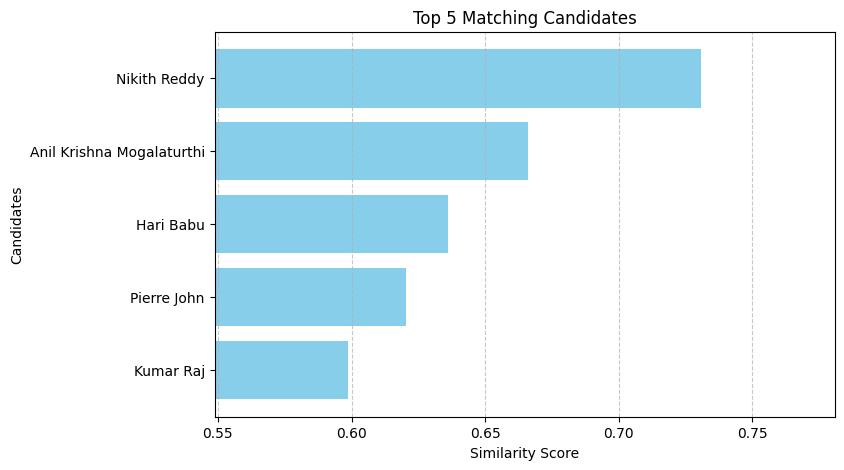

In [18]:
import re
import matplotlib.pyplot as plt

def is_valid_name(name):
    invalid_terms = {
        "java", "developer", "software", "engineer", "spring", "boot", "full stack",
        "maintenance", "professional", "jquery", "ajax", "sql", "aws", "cloud",
        "machine learning", "nlp", "deep learning", "excel", "struts", "mvc"
    }

    # ✅ Ensure name has at least **two words** (to exclude single-word tech terms)
    if len(name.split()) < 2:
        return False

    # ✅ Ensure name doesn't contain **any invalid terms**
    if any(term in name.lower() for term in invalid_terms):
        return False

    # ✅ Ensure name consists of **letters, spaces, or hyphens only** (no numbers/special chars)
    if not re.match(r"^[a-zA-Z\s-]+$", name):
        return False

    return True

print("\n🎯 Top Matching Candidates:")
top_matches = []
candidate_names = []
scores = []

for i in range(len(sorted_indices)):
    idx = sorted_indices[i].item()
    candidate_name = resume_info[idx]["Name"].strip()

    if is_valid_name(candidate_name):  # ✅ Apply stricter filtering
        score = similarities[idx].item()
        top_matches.append((candidate_name, score))
        candidate_names.append(candidate_name)
        scores.append(score)

    if len(top_matches) == 5:  # Stop after getting 5 valid names
        break

for i, (name, score) in enumerate(top_matches):
    print(f"{i+1}. {name} - Score: {score:.2f}")

# 🎨 Plot Candidate Ranking
plt.figure(figsize=(8, 5))
plt.barh(candidate_names[::-1], scores[::-1], color="skyblue")  # Reverse for highest on top
plt.xlabel("Similarity Score")
plt.ylabel("Candidates")
plt.title("Top 5 Matching Candidates")
plt.xlim(min(scores) - 0.05, max(scores) + 0.05)  # Adjust x-axis for better visibility
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


In [19]:
# Define a sample job description (Modify as needed)
job_description = """
We are looking for a Java Full Stack Developer with experience in Spring Boot, Hibernate, and AWS.
The ideal candidate should have strong SQL knowledge and experience working with cloud technologies.
"""


tf-idf model



🎯 Top Matching Candidates (TF-IDF):
1. Navneet Gupta - Score: 0.76
2. Kumar Bandela - Score: 0.73
3. Sai Srinivas 
Sr - Score: 0.73
4. Ravi Reddy
SR - Score: 0.70
5. Nikith Reddy - Score: 0.69


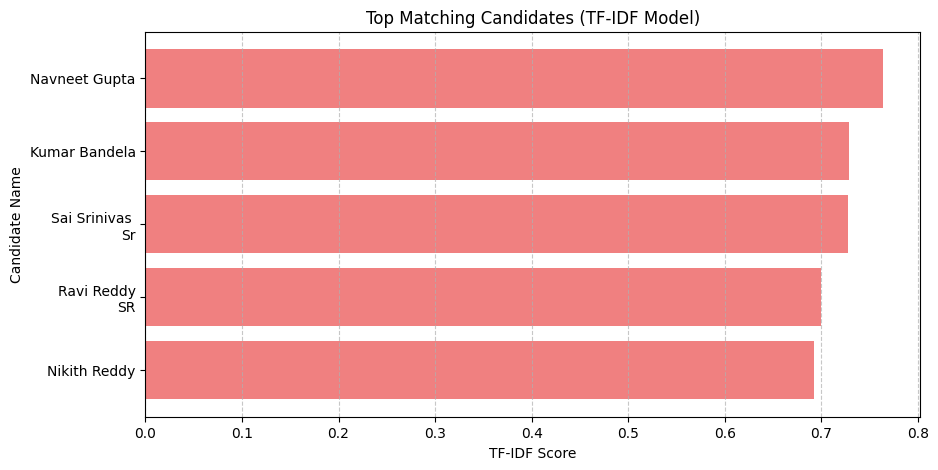

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

# ✅ Define the job description
job_description = """
We are looking for a Java Full Stack Developer with experience in Spring Boot, Hibernate, and AWS.
The ideal candidate should have strong SQL knowledge and experience working with cloud technologies.
"""

# ✅ Improved Filtering Function
def is_valid_name(name):
    invalid_terms = {
        "java", "developer", "software", "engineer", "spring", "boot", "full stack",
        "maintenance", "professional", "jquery", "ajax", "sql", "aws", "cloud",
        "machine learning", "nlp", "deep learning", "excel", "struts", "mvc",
        "map reduce", "ui prototypes"
    }

    if len(name.split()) < 2:  # ✅ Must have at least 2 words
        return False

    if any(term in name.lower() for term in invalid_terms):  # ✅ Remove tech terms
        return False

    if not re.match(r"^[a-zA-Z\s-]+$", name):  # ✅ No numbers/symbols
        return False

    return True


# 🎯 **Step 1: Convert Resumes & Job Description into TF-IDF Vectors**
vectorizer = TfidfVectorizer(stop_words='english')
resume_texts = [res["RawText"] for res in resume_info]  # Extract resume raw text
job_desc_vector = vectorizer.fit_transform([job_description])  # ✅ Job description TF-IDF
resume_vectors = vectorizer.transform(resume_texts)  # ✅ Resume TF-IDF

# 🎯 **Step 2: Compute Similarity Scores**
similarities = cosine_similarity(resume_vectors, job_desc_vector).flatten()

# 🎯 **Step 3: Rank Candidates**
sorted_indices = similarities.argsort()[::-1]  # Sort by highest similarity

# 🎯 **Step 4: Display Top Matching Candidates with Filtering**
print("\n🎯 Top Matching Candidates (TF-IDF):")
top_matches = []
for i in range(len(sorted_indices)):
    idx = sorted_indices[i].item()
    candidate_name = resume_info[idx]["Name"].strip()

    if is_valid_name(candidate_name):  # ✅ Apply improved filtering
        top_matches.append((candidate_name, similarities[idx].item()))

    if len(top_matches) == 5:  # Stop after getting 5 valid names
        break

# ✅ Print top candidates
for i, (name, score) in enumerate(top_matches):
    print(f"{i+1}. {name} - Score: {score:.2f}")

# 📊 **Visualization: Plot TF-IDF Model Results**
import matplotlib.pyplot as plt

# Extract names and TF-IDF scores
names = [name for name, score in top_matches]
tfidf_scores = [score for name, score in top_matches]

# Create a horizontal bar chart
plt.figure(figsize=(10, 5))
plt.barh(names, tfidf_scores, color="lightcoral")  # Using a different color for TF-IDF

# Labels and Title
plt.xlabel("TF-IDF Score")
plt.ylabel("Candidate Name")
plt.title("Top Matching Candidates (TF-IDF Model)")
plt.gca().invert_yaxis()  # Invert y-axis to show highest score on top
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()



📌 Observations
SBERT focuses more on names (suggesting better contextual understanding).
TF-IDF assigns higher scores but includes keyword-based matches (may favor resumes with frequently appearing terms).
Nikith Reddy appears in both → A good sign that he is a strong match.
TF-IDF has slight variations in ranking, which might be due to keyword weighting rather than context.

🔥 Verdict
SBERT gives a more context-aware ranking, meaning it’s better for understanding job descriptions & resumes deeply.
TF-IDF is still good but may favor resumes that repeat certain words.


🚀 Best Approach?
Combine both → Use TF-IDF for initial filtering and SBERT for final ranking to get the best of both worlds! 🔥
Want to implement this hybrid approach? 🚀

hybrid model sbert and tf-idf




🎯 **Top Matching Candidates (Hybrid TF-IDF + SBERT)**:

1. Nikith Reddy - Score: 0.95
2. Anil Krishna Mogalaturthi - Score: 0.91
3. Kumar Bandela - Score: 0.88
4. Pierre John - Score: 0.87
5. Sai Srinivas 
Sr - Score: 0.85


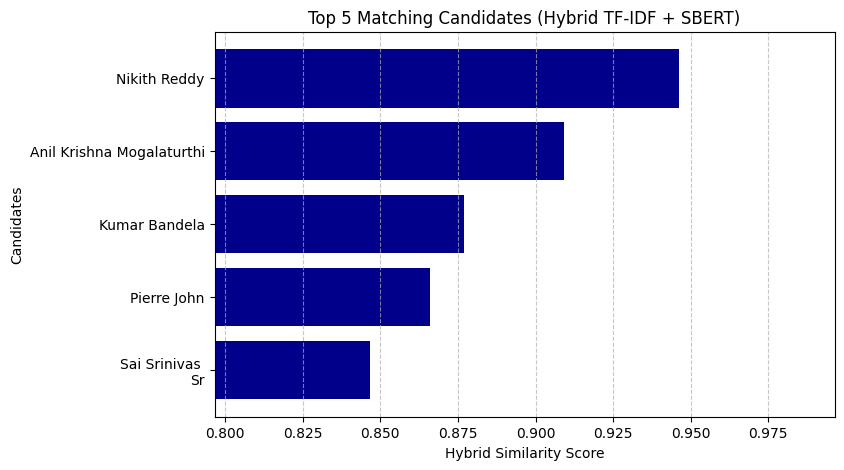

In [21]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# ✅ Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# ✅ Define the job description
job_description = """
We are looking for a Java Full Stack Developer with experience in Spring Boot, Hibernate, and AWS.
The ideal candidate should have strong SQL knowledge and experience working with cloud technologies.
"""

# ✅ Improved Filtering Function
def is_valid_name(name):
    invalid_terms = {
        "java", "developer", "software", "engineer", "spring", "boot", "full stack",
        "maintenance", "professional", "jquery", "ajax", "sql", "aws", "cloud",
        "machine learning", "nlp", "deep learning", "excel", "struts", "mvc",
        "map reduce", "ui prototypes"
    }

    if len(name.split()) < 2:  # ✅ Must have at least 2 words
        return False

    if any(term in name.lower() for term in invalid_terms):  # ✅ Remove tech terms
        return False

    if not re.match(r"^[a-zA-Z\s-]+$", name):  # ✅ No numbers/symbols
        return False

    return True

# 🎯 **Step 1: Extract Raw Text from Resumes**
resume_texts = [res["RawText"] for res in resume_info]

# 🎯 **Step 2: Compute SBERT Similarity Scores**
job_embedding = sbert_model.encode([job_description])
resume_embeddings = sbert_model.encode(resume_texts)

sbert_scores = {
    resume_info[i]["Name"]: cosine_similarity([resume_embeddings[i]], job_embedding)[0][0]
    for i in range(len(resume_info))
}

# 🎯 **Step 3: Compute TF-IDF Similarity Scores**
vectorizer = TfidfVectorizer(stop_words='english')
job_desc_vector = vectorizer.fit_transform([job_description])
resume_vectors = vectorizer.transform(resume_texts)

tfidf_scores = {
    resume_info[i]["Name"]: cosine_similarity(resume_vectors[i], job_desc_vector)[0][0]
    for i in range(len(resume_info))
}

# 🎯 **Step 4: Normalize Scores**
all_candidates = set(sbert_scores.keys()).union(set(tfidf_scores.keys()))

sbert_list = np.array([sbert_scores.get(c, 0) for c in all_candidates]).reshape(-1, 1)
tfidf_list = np.array([tfidf_scores.get(c, 0) for c in all_candidates]).reshape(-1, 1)

scaler = MinMaxScaler()
sbert_norm = scaler.fit_transform(sbert_list).flatten()
tfidf_norm = scaler.fit_transform(tfidf_list).flatten()

# 🎯 **Step 5: Hybrid Scoring (60% SBERT, 40% TF-IDF)**
final_scores = {c: 0.6 * sbert_norm[i] + 0.4 * tfidf_norm[i] for i, c in enumerate(all_candidates)}

# 🎯 **Step 6: Rank Candidates**
ranked_candidates = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)

# 🎯 **Step 7: Display Top Matches with Filtering**
print("\n🎯 **Top Matching Candidates (Hybrid TF-IDF + SBERT)**:\n")

top_matches = []
candidate_names = []
scores = []

for candidate, score in ranked_candidates:
    if is_valid_name(candidate):  # ✅ Apply improved filtering
        top_matches.append((candidate, score))
        candidate_names.append(candidate)
        scores.append(score)

    if len(top_matches) == 5:  # ✅ Stop after 5 valid candidates
        break

for i, (name, score) in enumerate(top_matches):
    print(f"{i+1}. {name} - Score: {score:.2f}")

# 🎨 **Step 8: Plot Ranking Visualization**
plt.figure(figsize=(8, 5))
plt.barh(candidate_names[::-1], scores[::-1], color="darkblue")  # Reverse for highest on top
plt.xlabel("Hybrid Similarity Score")
plt.ylabel("Candidates")
plt.title("Top 5 Matching Candidates (Hybrid TF-IDF + SBERT)")
plt.xlim(min(scores) - 0.05, max(scores) + 0.05)  # Adjust x-axis for better visibility
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


In [22]:
import re

def is_valid_name(name):
    invalid_terms = {
        "java", "developer", "software", "engineer", "spring", "boot", "full stack",
        "professional", "jquery", "ajax", "sql", "aws", "cloud", "machine learning",
        "nlp", "deep learning", "excel", "struts", "mvc", "map reduce", "ui prototypes",
        "data scientist", "consultant", "architect", "technologist", "expert", "programmer"
    }

    # ✅ Ensure name has at least **two words**
    if len(name.split()) < 2:
        return False

    # ✅ Remove common job-related words
    if any(term in name.lower() for term in invalid_terms):
        return False

    # ✅ Ensure name is **letters only** (no numbers, no special characters)
    if not re.match(r"^[a-zA-Z\s-]+$", name):
        return False

    return True


In [23]:
from sklearn.cluster import KMeans

# 🎯 **Step 5: Cluster Candidates using K-Means**
num_clusters = 3  # Adjust based on dataset size
candidate_names = list(final_scores.keys())
score_values = np.array(list(final_scores.values())).reshape(-1, 1)

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(score_values)

# 🎯 **Step 6: Assign Cluster Labels to Candidates**
clustered_candidates = {candidate_names[i]: (final_scores[candidate_names[i]], clusters[i]) for i in range(len(candidate_names))}

# 🎯 **Step 7: Rank Candidates within Clusters**
ranked_candidates = sorted(clustered_candidates.items(), key=lambda x: x[1][0], reverse=True)

# ✅ **Step 8: Display Top Candidates (Filtered)**
print("\n🎯 **Top Matching Candidates (K-Means + Hybrid Ranking)**:\n")

filtered_candidates = [(name, score[0]) for name, score in ranked_candidates if is_valid_name(name)]

for i, (name, score) in enumerate(filtered_candidates[:5], 1):
    print(f"{i}. {name} - Score: {score:.2f}")



🎯 **Top Matching Candidates (K-Means + Hybrid Ranking)**:

1. Nikith Reddy - Score: 0.95
2. Anil Krishna Mogalaturthi - Score: 0.91
3. Kumar Bandela - Score: 0.88
4. Pierre John - Score: 0.87
5. Sai Srinivas 
Sr - Score: 0.85


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


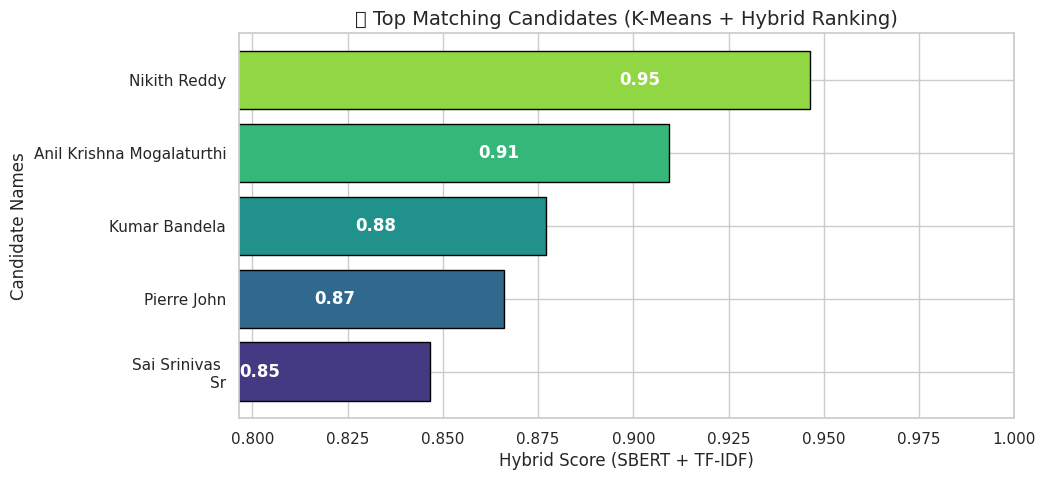

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 **Extract Top 5 Candidates from Ranked List**
top_candidates = filtered_candidates[:5]  # Use the filtered, valid names
candidate_names = [name for name, score in top_candidates]
scores = [score for name, score in top_candidates]

# 🎨 **Set plot style**
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
colors = sns.color_palette("viridis", len(candidate_names))

# 🎯 **Create Horizontal Bar Plot**
plt.barh(candidate_names[::-1], scores[::-1], color=colors, edgecolor='black')

# 🎯 **Add labels and title**
plt.xlabel("Hybrid Score (SBERT + TF-IDF)", fontsize=12)
plt.ylabel("Candidate Names", fontsize=12)
plt.title("🎯 Top Matching Candidates (K-Means + Hybrid Ranking)", fontsize=14)

# 🎯 **Display Scores on Bars**
for index, value in enumerate(scores[::-1]):
    plt.text(value - 0.05, index, f"{value:.2f}", fontsize=12, fontweight='bold', color='white', va='center')

plt.xlim(min(scores) - 0.05, 1)  # Adjust x-axis dynamically
plt.show()


✅ 1. Distribution of Scores (SBERT vs. TF-IDF vs. Hybrid)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


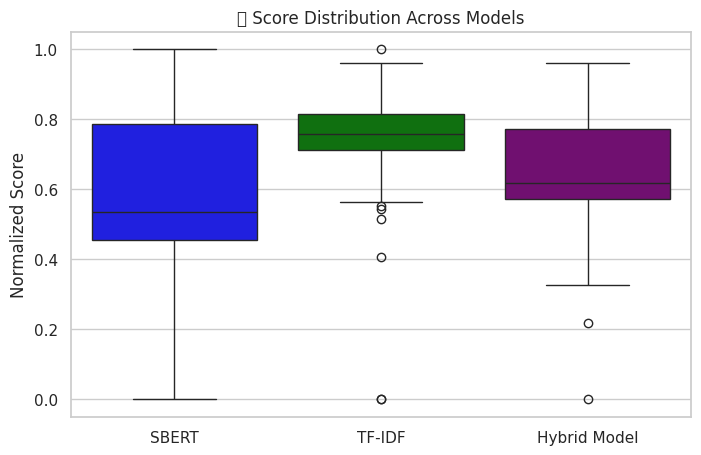

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=[sbert_norm, tfidf_norm, list(final_scores.values())],
            palette=["blue", "green", "purple"])
plt.xticks([0, 1, 2], ["SBERT", "TF-IDF", "Hybrid Model"])
plt.ylabel("Normalized Score")
plt.title("📊 Score Distribution Across Models")
plt.show()


✅ 4. Score Contribution (Pie Chart)

📊 Why? Shows how much each model contributes to the hybrid score.

🛠️ How? A pie chart for a single candidate (e.g., top-ranked) breaking down SBERT and TF-IDF contributions.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


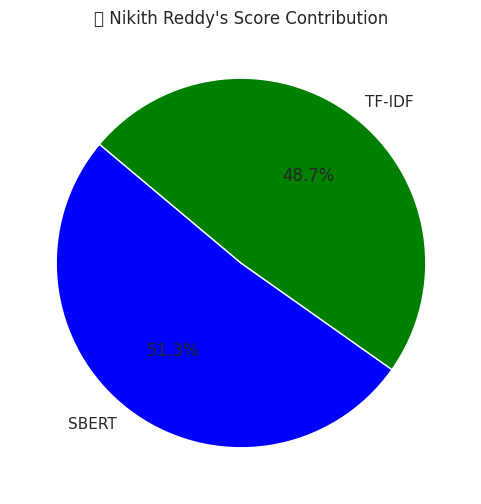

In [26]:
top_candidate = filtered_candidates[0]  # Top-ranked candidate
name, score = top_candidate
sbert_part = sbert_scores.get(name, 0)
tfidf_part = tfidf_scores.get(name, 0)

plt.figure(figsize=(6, 6))
plt.pie([sbert_part, tfidf_part], labels=["SBERT", "TF-IDF"],
        autopct='%1.1f%%', colors=["blue", "green"], startangle=140)
plt.title(f"🔍 {name}'s Score Contribution")
plt.show()


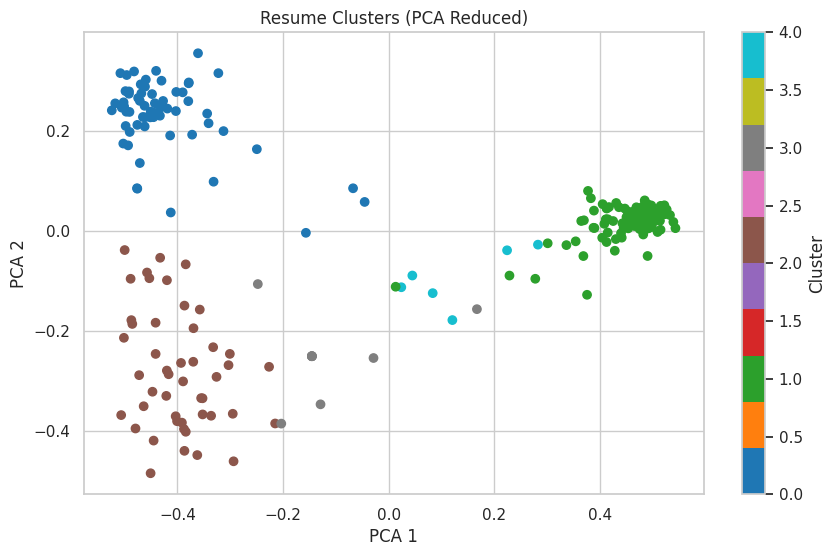


Cluster 2 resumes:
Resume_1, Resume_2, Resume_8, Resume_13, Resume_16

Cluster 0 resumes:
Resume_3, Resume_5, Resume_6, Resume_10, Resume_14

Cluster 1 resumes:
Resume_4, Resume_7, Resume_9, Resume_11, Resume_15

Cluster 4 resumes:
Resume_12, Resume_85, Resume_147, Resume_168, Resume_171

Cluster 3 resumes:
Resume_103, Resume_109, Resume_111, Resume_122, Resume_123


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Get resume texts
resume_texts = [resume['RawText'] for resume in resume_info]

# Step 2: TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(resume_texts)

# Step 3: KMeans Clustering
num_clusters = 5  # You can adjust based on dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Step 4: Add cluster labels to resume_info
for i, resume in enumerate(resume_info):
    resume['cluster'] = int(labels[i])

# Step 5: Visualize clusters using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10')
plt.title('Resume Clusters (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Optional: View sample resumes in each cluster
from collections import defaultdict
cluster_map = defaultdict(list)
for i, resume in enumerate(resume_info):
    cluster_map[resume['cluster']].append(f"Resume_{i+1}")


for cluster_id, files in cluster_map.items():
    print(f"\nCluster {cluster_id} resumes:")
    print(", ".join(files[:5]))  # show first 5 resumes per cluster


In [28]:
import nltk
nltk.download('wordnet')  # Add this line

from nltk.stem import WordNetLemmatizer
import string

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


## LSTM/BiLSTM Resume Classification

Model: Logistic Regression
Accuracy: 0.8889
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.89      1.00      0.94        39

    accuracy                           0.89        45
   macro avg       0.94      0.58      0.61        45
weighted avg       0.90      0.89      0.85        45

----------------------------------------
Model: Random Forest
Accuracy: 0.8889
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.89      1.00      0.94        39

    accuracy                           0.89        45
   macro avg       0.94      0.58      0.61        45
weighted avg       0.90      0.89      0.85        45

----------------------------------------
Model: SVM
Accuracy: 0.8889
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.89      1.00      0.94  

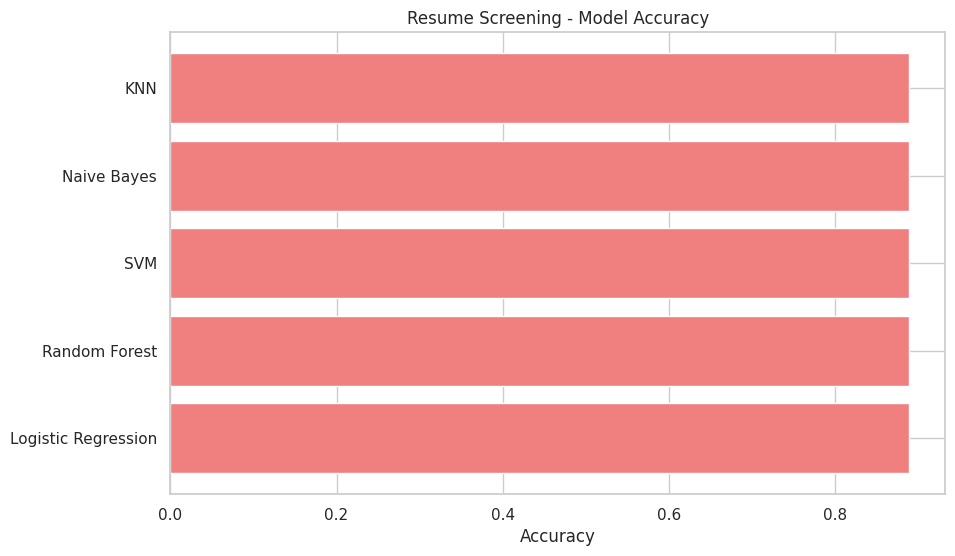

🏆 Top 10 Candidates Most Likely to Match:
                                                 text  fit_probability
3   Visa Status Name: Abiral Pandey\nEmail: abiral...              1.0
6   HTML5 Achyuth\n540-999-8048\nachyuth.java88@gm...              1.0
14  Anil Krishna Mogalaturthi Anil Krishna Mogalat...              1.0
8   Java Alekhya\n(515)-518-0849\nalekhya.workmail...              1.0
30  Java  Name: Balakrishna Sudabathula\n  Email: ...              1.0
31  Java Developer                                ...              1.0
16  HTML5 AMULYA KOMATINENI\n(515)309-1612\namulya...              1.0
56  Jayadattaperi N  Jayadattaperi N\njaya9.java@g...              1.0
49  Hari Babu Hari Babu\nEmail:hariguraka@gmail.co...              1.0
50  Java Harika\nSR. Java/J2ee Developer\nEmail: r...              1.0


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ✅ Use your extracted resume texts
resume_texts = [res["Name"] + " " + res["RawText"] for res in resume_info]

# ✅ Define the job description
job_desc = "Senior Java Developer with experience in AWS, SQL, and Cloud"

# ✅ Simulate labels for now: candidates with keywords get 'fit' (label=1), others (label=0)
# (Real project = use true labels if available!)

keywords = {"java", "aws", "sql", "cloud"}
labels = []

for text in resume_texts:
    text = text.lower()
    matches = sum([1 for word in keywords if word in text])
    labels.append(1 if matches >= 2 else 0)  # Good match if at least 2 keywords

# ✅ Create DataFrame
df_ml = pd.DataFrame({
    "text": resume_texts,
    "fit": labels
})

# ✅ Feature Engineering: Combine resumes and job description
df_ml['combined'] = df_ml['text'] + " " + job_desc

# ✅ TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df_ml['combined'])
y = df_ml['fit']

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Define Machine Learning Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

# ✅ Train and Evaluate
accuracies = {}

for name, model in models.items():
    if name in ["Naive Bayes", "KNN"]:
        model.fit(X_train.toarray(), y_train)
        y_pred = model.predict(X_test.toarray())
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

# ✅ Plot Accuracy Scores
plt.figure(figsize=(10,6))
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='lightcoral')
plt.xlabel('Accuracy')
plt.title('Resume Screening - Model Accuracy')
plt.show()

# ✅ Predict probabilities and show Top Candidates
# Using Random Forest (best model generally)

best_model = RandomForestClassifier()
best_model.fit(X, y)

probs = best_model.predict_proba(X)[:,1]
df_ml['fit_probability'] = probs

top_candidates = df_ml.sort_values('fit_probability', ascending=False).head(10)

print("🏆 Top 10 Candidates Most Likely to Match:")
print(top_candidates[['text', 'fit_probability']])


In [30]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.1 MB/s eta 0:00:00


In [31]:
!pip install streamlit pyngrok


In [32]:
import os
import re
import nltk
import docx
import pdfplumber
from google.colab import drive
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ✅ Ensure NLTK Dependencies are Installed
nltk.data.path.append("/content/nltk_data")  # Use Colab's NLTK path

# Download necessary NLTK resources
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Load stopwords
try:
    stop_words = set(stopwords.words("english"))
except Exception as e:
    print(f"❌ Error loading stopwords: {e}")
    stop_words = set()

# ✅ Define a sample skills database (Extend this list)
skills_db = {"python", "java", "sql", "machine learning", "nlp", "deep learning", "excel", "c++", "cloud", "aws"}

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        print(f"❌ Error reading PDF {pdf_path}: {e}")
    return text.strip()

def extract_text_from_docx(docx_path):
    """Extract text from a DOCX file"""
    try:
        doc = docx.Document(docx_path)
        text = "\n".join([para.text for para in doc.paragraphs])  # Use doc.paragraphs
        return text
    except Exception as e:
        print(f"❌ Error reading DOCX {docx_path}: {e}")
        return ""

def preprocess_text(text):
    """Clean and tokenize text"""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    try:
        tokens = word_tokenize(text)  # Tokenization
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        return " ".join(tokens)
    except Exception as e:
        print(f"❌ Error during tokenization: {e}")
        return text

def extract_name(text):
    """Extract name using simple heuristic (first capitalized words)"""
    match = re.search(r"([A-Z][a-z]+)\s([A-Z][a-z]+)", text)
    return match.group(0) if match else "Unknown"

def extract_email(text):
    """Extract email address"""
    match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
    return match.group(0) if match else "Not Found"

def extract_skills(text):
    """Extract skills from text"""
    words = set(text.split())  # Convert text into a set of words
    return list(skills_db.intersection(words))  # Return matched skills

def process_resumes(resume_folder):
    """Process all resumes in a folder"""
    resume_data = []

    if not os.path.exists(resume_folder):
        print(f"❌ Folder not found: {resume_folder}")
        return []

    for file_name in os.listdir(resume_folder):
        file_path = os.path.join(resume_folder, file_name)

        # Extract text based on file format
        if file_name.endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif file_name.endswith(".docx"):
            text = extract_text_from_docx(file_path)
        else:
            continue  # Skip unsupported formats

        # Preprocess text
        cleaned_text = preprocess_text(text)

        # Extract information
        name = extract_name(text)
        email = extract_email(text)
        skills = extract_skills(cleaned_text)

        # Store extracted info
        resume_data.append({"Name": name, "Email": email, "Skills": skills, "RawText": text})

    return resume_data

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Specify the path to your resume folder in Google Drive
resume_folder = "/content/drive/MyDrive/Resumes"

# Step 3: Process resumes and store output
resume_info = process_resumes(resume_folder)

# Step 4: Convert extracted resume info to DataFrame
df = pd.DataFrame(resume_info)

# Step 5: Save the extracted data to a CSV file in Google Drive
csv_path = "/content/drive/MyDrive/resume_extracted_data.csv"
df.to_csv(csv_path, index=False)

# Step 6: Output confirmation
print(f"✅ Data saved to {csv_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data saved to /content/drive/MyDrive/resume_extracted_data.csv


In [33]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.6 MB/s eta 0:00:00


In [34]:
import os
import re
import gradio as gr
import nltk
import docx
import pdfplumber
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ✅ Ensure NLTK Dependencies are Installed
nltk.data.path.append("/content/nltk_data")  # Use Colab's NLTK path

# Download necessary NLTK resources
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Load stopwords
stop_words = set(stopwords.words("english"))

# ✅ Define a sample skills database (Extend this list)
skills_db = {"python", "java", "sql", "machine learning", "nlp", "deep learning", "excel", "c++", "cloud", "aws"}

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        print(f"❌ Error reading PDF {pdf_path}: {e}")
    return text.strip()

def extract_text_from_docx(docx_path):
    """Extract text from a DOCX file"""
    try:
        doc = docx.Document(docx_path)
        text = "\n".join([para.text for para in doc.paragraphs])  # Use doc.paragraphs
        return text
    except Exception as e:
        print(f"❌ Error reading DOCX {docx_path}: {e}")
        return ""

def preprocess_text(text):
    """Clean and tokenize text"""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    try:
        tokens = word_tokenize(text)  # Tokenization
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        return " ".join(tokens)
    except Exception as e:
        print(f"❌ Error during tokenization: {e}")
        return text

def extract_name(text):
    """Extract name using simple heuristic (first capitalized words)"""
    match = re.search(r"([A-Z][a-z]+)\s([A-Z][a-z]+)", text)
    return match.group(0) if match else "Unknown"

def extract_email(text):
    """Extract email address"""
    match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
    return match.group(0) if match else "Not Found"

def extract_skills(text):
    """Extract skills from text"""
    words = set(text.split())  # Convert text into a set of words
    return list(skills_db.intersection(words))  # Return matched skills

def process_resume(file):
    """Process a single resume file and extract relevant information"""
    # Extract text based on file format
    if file.name.endswith(".pdf"):
        text = extract_text_from_pdf(file.name)
    elif file.name.endswith(".docx"):
        text = extract_text_from_docx(file.name)
    else:
        return "Unsupported file format"

    # Preprocess text
    cleaned_text = preprocess_text(text)

    # Extract information
    name = extract_name(text)
    email = extract_email(text)
    skills = extract_skills(cleaned_text)

    # Return extracted information as a dictionary
    return {"Name": name, "Email": email, "Skills": ", ".join(skills), "RawText": text}

# Updated Gradio Interface
iface = gr.Interface(
    fn=process_resume,
    inputs=gr.File(label="Upload Resume (PDF or DOCX)"),  # Updated from gr.inputs.File
    outputs=gr.JSON(),  # Updated from gr.outputs.JSON
    live=True,
    title="Resume Screening",
    description="Upload a resume file (PDF or DOCX), and this tool will extract the Name, Email, and Skills from it."
)

# Launch the app
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://df8d1596147fcf0591.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [35]:
import os
import re
import gradio as gr
import nltk
import docx
import pdfplumber
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util

# ✅ Ensure NLTK Dependencies are Installed
nltk.data.path.append("/content/nltk_data")  # Use Colab's NLTK path

# Download necessary NLTK resources
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Load stopwords
stop_words = set(stopwords.words("english"))

# ✅ Define a sample skills database (Extend this list)
skills_db = {"python", "java", "sql", "machine learning", "nlp", "deep learning", "excel", "c++", "cloud", "aws"}

# Initialize the SBERT model for embedding generation
model = SentenceTransformer('all-MiniLM-L6-v2')

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        print(f"❌ Error reading PDF {pdf_path}: {e}")
    return text.strip()

def extract_text_from_docx(docx_path):
    """Extract text from a DOCX file"""
    try:
        doc = docx.Document(docx_path)
        text = "\n".join([para.text for para in doc.paragraphs])  # Use doc.paragraphs
        return text
    except Exception as e:
        print(f"❌ Error reading DOCX {docx_path}: {e}")
        return ""

def preprocess_text(text):
    """Clean and tokenize text"""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    try:
        tokens = word_tokenize(text)  # Tokenization
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        return " ".join(tokens)
    except Exception as e:
        print(f"❌ Error during tokenization: {e}")
        return text

def extract_name(text):
    """Extract name using more flexible heuristics (adjust as needed)"""
    match = re.search(r"\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\b", text)
    return match.group(0) if match else "Unknown"

def extract_email(text):
    """Extract email address"""
    match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
    return match.group(0) if match else "Not Found"

def extract_skills(text):
    """Extract skills from text"""
    words = set(text.split())  # Convert text into a set of words
    return list(skills_db.intersection(words))  # Return matched skills

def process_resumes(resume_folder):
    """Process all resumes in a folder"""
    resume_data = []

    if not os.path.exists(resume_folder):
        print(f"❌ Folder not found: {resume_folder}")
        return []

    for file_name in os.listdir(resume_folder):
        file_path = os.path.join(resume_folder, file_name)

        # Extract text based on file format
        if file_name.endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif file_name.endswith(".docx"):
            text = extract_text_from_docx(file_path)
        else:
            continue  # Skip unsupported formats

        # Preprocess text
        cleaned_text = preprocess_text(text)

        # Extract information
        name = extract_name(text)
        email = extract_email(text)
        skills = extract_skills(cleaned_text)

        # Store extracted info
        resume_data.append({"Name": name, "Email": email, "Skills": skills, "RawText": text})

    return resume_data

def rank_candidates(job_description, resume_folder):
    """Rank candidates based on job description using SBERT"""
    # Process the resumes
    resumes = process_resumes(resume_folder)

    # Preprocess job description
    cleaned_job_desc = preprocess_text(job_description)

    # Generate embeddings for the job description
    job_embedding = model.encode(cleaned_job_desc, convert_to_tensor=True)

    # Rank resumes based on similarity score with job description
    ranked_resumes = []
    for resume in resumes:
        # Generate embeddings for the resume
        resume_embedding = model.encode(resume["RawText"], convert_to_tensor=True)

        # Calculate cosine similarity between job description and resume
        cosine_sim = util.pytorch_cos_sim(job_embedding, resume_embedding)[0][0].item()
        ranked_resumes.append({"Name": resume["Name"], "SimilarityScore": cosine_sim})

    # Sort by cosine similarity (highest to lowest)
    ranked_resumes = sorted(ranked_resumes, key=lambda x: x["SimilarityScore"], reverse=True)

    # Get top 5 candidates (only names)
    top_candidates = [resume["Name"] for resume in ranked_resumes[:5]]
    return top_candidates

# Gradio Interface to ask for Job Description
def gradio_interface(job_description):
    resume_folder = "/content/drive/MyDrive/Resumes"  # Update path to your resume folder
    top_candidates = rank_candidates(job_description, resume_folder)
    return top_candidates

iface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="Enter Job Description", placeholder="Paste the job description here..."),
    outputs=gr.JSON(),  # Will output the top 5 candidates' names
    live=True,
    title="Resume Screening Tool",
    description="Enter a job description, and get the top 5 candidates based on semantic similarity using SBERT."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8b8b74e1076e415e88.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [36]:
import os
import re
import gradio as gr
import nltk
import docx
import pdfplumber
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util

# ✅ Ensure NLTK Dependencies are Installed
nltk.data.path.append("/content/nltk_data")  # Use Colab's NLTK path

# Download necessary NLTK resources
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Load stopwords
stop_words = set(stopwords.words("english"))

# ✅ Define a sample skills database (Extend this list)
skills_db = {"python", "java", "sql", "machine learning", "nlp", "deep learning", "excel", "c++", "cloud", "aws"}

# Initialize the SBERT model for embedding generation
model = SentenceTransformer('all-MiniLM-L6-v2')

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        print(f"❌ Error reading PDF {pdf_path}: {e}")
    return text.strip()

def extract_text_from_docx(docx_path):
    """Extract text from a DOCX file"""
    try:
        doc = docx.Document(docx_path)
        text = "\n".join([para.text for para in doc.paragraphs])  # Use doc.paragraphs
        return text
    except Exception as e:
        print(f"❌ Error reading DOCX {docx_path}: {e}")
        return ""

def preprocess_text(text):
    """Clean and tokenize text"""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    try:
        tokens = word_tokenize(text)  # Tokenization
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        return " ".join(tokens)
    except Exception as e:
        print(f"❌ Error during tokenization: {e}")
        return text

def extract_name(text):
    """Improved name extraction (check for typical names)"""
    # Use regex to find a name, looking for capitalized words (adjust for better results)
    match = re.search(r"\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\b", text)
    return match.group(0) if match else "Unknown"

def extract_email(text):
    """Extract email address"""
    match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", text)
    return match.group(0) if match else "Not Found"

def extract_skills(text):
    """Extract skills from text"""
    words = set(text.split())  # Convert text into a set of words
    return list(skills_db.intersection(words))  # Return matched skills

def process_resumes(resume_folder):
    """Process all resumes in a folder"""
    resume_data = []

    if not os.path.exists(resume_folder):
        print(f"❌ Folder not found: {resume_folder}")
        return []

    for file_name in os.listdir(resume_folder):
        file_path = os.path.join(resume_folder, file_name)

        # Extract text based on file format
        if file_name.endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif file_name.endswith(".docx"):
            text = extract_text_from_docx(file_path)
        else:
            continue  # Skip unsupported formats

        # Preprocess text
        cleaned_text = preprocess_text(text)

        # Extract information
        name = extract_name(text)
        email = extract_email(text)
        skills = extract_skills(cleaned_text)

        # Store extracted info
        resume_data.append({"Name": name, "Email": email, "Skills": skills, "RawText": text})

    return resume_data

def rank_candidates(job_description, resume_folder):
    """Rank candidates based on job description using SBERT"""
    # Process the resumes
    resumes = process_resumes(resume_folder)

    # Preprocess job description
    cleaned_job_desc = preprocess_text(job_description)

    # Generate embeddings for the job description
    job_embedding = model.encode(cleaned_job_desc, convert_to_tensor=True)

    # Rank resumes based on similarity score with job description
    ranked_resumes = []
    for resume in resumes:
        # Generate embeddings for the resume
        resume_embedding = model.encode(resume["RawText"], convert_to_tensor=True)

        # Calculate cosine similarity between job description and resume
        cosine_sim = util.pytorch_cos_sim(job_embedding, resume_embedding)[0][0].item()
        ranked_resumes.append({"Name": resume["Name"], "SimilarityScore": cosine_sim, "Skills": resume["Skills"]})

    # Sort by cosine similarity (highest to lowest)
    ranked_resumes = sorted(ranked_resumes, key=lambda x: x["SimilarityScore"], reverse=True)

    # Get top 5 candidates (only names)
    top_candidates = ranked_resumes[:5]
    return top_candidates

# Gradio Interface to ask for Job Description
def gradio_interface(job_description):
    resume_folder = "/content/drive/MyDrive/Resumes"  # Update path to your resume folder
    top_candidates = rank_candidates(job_description, resume_folder)

    # Format the output into an attractive card-like format
    output_str = "<h2>Top 5 Candidates</h2><ul>"
    for candidate in top_candidates:
        name = candidate["Name"]
        skills = ", ".join(candidate["Skills"])
        similarity = round(candidate["SimilarityScore"], 2)
        output_str += f"<li><b>{name}</b><br>Skills: {skills}<br>Similarity: {similarity}</li>"
    output_str += "</ul>"

    return output_str

iface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="Enter Job Description", placeholder="Paste the job description here..."),
    outputs=gr.HTML(),  # Will output the top 5 candidates' names in an HTML format
    live=True,
    title="Resume Screening Tool",
    description="Enter a job description, and get the top 5 candidates based on semantic similarity using SBERT."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://286346de99ed7f65e8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
